In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt


# this is the server which hosts all the patient data.
# in the real-world this would be an EHR vendor
# this is a open-source server with synthetic data for developers to learn and create apps
FHIR_BASE = "http://hapi.fhir.org/baseR4"


In [2]:
# Healthcare applications rarely store all their own data. Instead, they
# exchange information with electronic health record (EHR) systems using
# standards. FHIR (Fast Healthcare Interoperability Resources) is a standard
# based on RESTful web API ideas and allows for retrieving patient information
# from an EHR AND adding information to an EHR (provided the application has
# authorization)

# In this tutorial, we will walk through how to interact with a public FHIR
# server to get information about a patient.

# We will also create a synthetic patient with clinical information (because the
# public servers often don't have the test patients we might need)

# Pretend you are building a new health application for patients which will show
# them some health trends and their current medications. The app should be able
# to:
#   - Retrieve health data such as blood pressure, heart rate, and lab results
#   - Retrieve active medications

# Pull this information back out and display it as tables and charts so patients
# can see trends in their health over time

# By the end of this exercise, you’ll have a toy prototype that demonstrates how
# a modern health application can connect to a standards-based health data
# source.

In [3]:
# let's query the FHIR server to get information about a patient.
# we'll find up to 5 patients with last name "Smith" (chosen because these
# public servers often use this name)

# Recall that everything in FHIR is a "Resource" (patients, observations, etc)

resp = requests.get(f"{FHIR_BASE}/Patient", params={"name": "Smith", "_count": 5})
patients = resp.json()

for entry in patients.get("entry", []):
    patient = entry["resource"]
    print(patient["id"], patient.get("name"))


597226 [{'use': 'official', 'family': 'Smith', 'given': ['Sean']}]
597372 [{'family': 'Joe', 'given': ['Smith']}]
597502 [{'family': 'Joe', 'given': ['Smith']}]
597509 [{'family': 'Joe', 'given': ['Smith']}]
618626 [{'use': 'official', 'text': 'Julia Smith', 'family': 'Smith', 'given': ['Julia']}]


In [4]:
# we can see that there are 3 patients with this last name. each has a unique ID
# let's look at "Observations" from the first, limiting to the first 50

patient_id = "pat2"  # replace with real ID from above
resp = requests.get(f"{FHIR_BASE}/Observation", params={"patient": patient_id, "_count": 50})
obs = resp.json()

# and now let's print out all the observations
obs

# it's a lot! copy into a JSON viewer to look at the structure
# https://jsonviewer.stack.hu/


{'resourceType': 'Bundle',
 'id': '5ce8ae1d-b358-4f20-813c-710fe72ec8f0',
 'meta': {'lastUpdated': '2025-10-14T19:32:25.539+00:00'},
 'type': 'searchset',
 'link': [{'relation': 'self',
   'url': 'https://hapi.fhir.org/baseR4/Observation?_count=50&patient=pat2'},
  {'relation': 'next',
   'url': 'https://hapi.fhir.org/baseR4?_getpages=5ce8ae1d-b358-4f20-813c-710fe72ec8f0&_getpagesoffset=50&_count=50&_pretty=true&_bundletype=searchset'}],
 'entry': [{'fullUrl': 'https://hapi.fhir.org/baseR4/Observation/697307',
   'resource': {'resourceType': 'Observation',
    'id': '697307',
    'meta': {'versionId': '1',
     'lastUpdated': '2020-03-21T13:35:12.175+00:00',
     'source': '#jRCIxW3OQ18JILOr'},
    'identifier': [{'system': 'http://acme.com/lab/observation',
      'value': 'ObserationId_5234342'}],
    'status': 'final',
    'code': {'coding': [{'system': 'http://loinc.org',
       'code': '35200-5',
       'display': 'Cholesterol [Moles/\u200bvolume] in Serum or Plasma'}],
     'text'

In [5]:
# let's write some code to unpack this. the results come back as a bundle and we
# can use our json viewer to see that part of this is a list of resources
# in each resource we can find the lab names and values!
observations = []

for entry in obs.get("entry", []):
    resource = entry["resource"]

    if resource.get("code", {}).get("coding"):
      code = resource.get("code", {}).get("coding")[0].get("display")
      value = resource.get("valueQuantity", {}).get("value")
      unit = resource.get("valueQuantity", {}).get("unit")
      time = resource.get("effectiveDateTime")
    else:
        print("Skipping entry due to missing 'coding' information.")

    if value:
        observations.append({"code": code, "value": value, "unit": unit, "time": time})

df = pd.DataFrame(observations)
print(df.head())



Skipping entry due to missing 'coding' information.
                                                code  value      unit  time
0     Cholesterol [Moles/​volume] in Serum or Plasma    6.3    mmol/L  None
1                  Hemoglobin [Mass/volume] in Blood  176.0       g/L  None
2  Erythrocytes [#/volume] in Blood by Automated ...    5.9  x10*12/L  None
3  Hematocrit [Volume Fraction] of Blood by Autom...   55.0         %  None
4  Erythrocyte mean corpuscular volume [Entitic v...   99.0        fL  None


In [6]:
# as you can see this is a random collection of labs... for our app we need more
# detail.

# let's create our own patient now so we have control over the data
# we are allowed to do this because it is a public endpoint
# this paitent will be purged at some interval




In [7]:
# this makes a fake new  patient
# if everything goes well, we'll get a 201 response and an ID

new_patients = [
    {
        "resourceType": "Patient",
        "name": [{"use": "official", "family": "Doe", "given": ["Jane"]}],
        "gender": "female",
        "birthDate": "1980-05-01"
    },
    {
        'resourceType': 'Patient',
        'name': [{'use': 'official', 'family': 'Smith', 'given': ['Martina']}],
        'gender': 'female',
        'birthDate': '2003-12-05'
    }
]

for patient in new_patients:
  resp = requests.post(f"{FHIR_BASE}/Patient", json=patient)
  print(resp.status_code, resp.json())
  patient_id = resp.json()["id"]
  print("New Patient ID:", patient_id)


201 {'resourceType': 'Patient', 'id': '50166462', 'meta': {'versionId': '1', 'lastUpdated': '2025-10-14T19:32:26.538+00:00', 'source': '#SLK7GQSXIsyva99D'}, 'text': {'status': 'generated', 'div': '<div xmlns="http://www.w3.org/1999/xhtml"><div class="hapiHeaderText">Jane <b>DOE </b></div><table class="hapiPropertyTable"><tbody><tr><td>Date of birth</td><td><span>01 May 1980</span></td></tr></tbody></table></div>'}, 'name': [{'use': 'official', 'family': 'Doe', 'given': ['Jane']}], 'gender': 'female', 'birthDate': '1980-05-01'}
New Patient ID: 50166462
201 {'resourceType': 'Patient', 'id': '50166463', 'meta': {'versionId': '1', 'lastUpdated': '2025-10-14T19:32:27.539+00:00', 'source': '#muB8mQMNTyb8xEUK'}, 'text': {'status': 'generated', 'div': '<div xmlns="http://www.w3.org/1999/xhtml"><div class="hapiHeaderText">Martina <b>SMITH </b></div><table class="hapiPropertyTable"><tbody><tr><td>Date of birth</td><td><span>05 December 2003</span></td></tr></tbody></table></div>'}, 'name': [{'us

In [8]:
patient_id = resp.json()["id"]
print("New Patient ID:", patient_id)


New Patient ID: 50166463


In [9]:
# let's add a bunch of random data, one set of observations per day

from random import randint, gauss
from datetime import datetime, timedelta

base_date = datetime(2025, 8, 1)

observations = []
for i in range(5):  # 5 days
    dt = (base_date + timedelta(days=i)).isoformat() + "Z"

    observations += [
        {
            "resourceType": "Observation",
            "status": "final",
            "category": [{"coding": [{"system": "http://terminology.hl7.org/CodeSystem/observation-category",
                                      "code": "vital-signs"}]}],
            "code": {"text": "Systolic Blood Pressure"},
            "subject": {"reference": f"Patient/{patient_id}"},
            "effectiveDateTime": dt,
            "valueQuantity": {"value": randint(110, 135), "unit": "mmHg"}
        },
        {
            "resourceType": "Observation",
            "status": "final",
            "category": [{"coding": [{"system": "http://terminology.hl7.org/CodeSystem/observation-category",
                                      "code": "vital-signs"}]}],
            "code": {"text": "Diastolic Blood Pressure"},
            "subject": {"reference": f"Patient/{patient_id}"},
            "effectiveDateTime": dt,
            "valueQuantity": {"value": randint(70, 90), "unit": "mmHg"}
        },
        {
            "resourceType": "Observation",
            "status": "final",
            "category": [{"coding": [{"system": "http://terminology.hl7.org/CodeSystem/observation-category",
                                      "code": "vital-signs"}]}],
            "code": {"text": "Heart rate"},
            "subject": {"reference": f"Patient/{patient_id}"},
            "effectiveDateTime": dt,
            "valueQuantity": {"value": randint(65, 90), "unit": "beats/min"}
        },
        {
            "resourceType": "Observation",
            "status": "final",
            "category": [{"coding": [{"system": "http://terminology.hl7.org/CodeSystem/observation-category",
                                      "code": "laboratory"}]}],
            "code": {"text": "Glucose"},
            "subject": {"reference": f"Patient/{patient_id}"},
            "effectiveDateTime": dt,
            "valueQuantity": {"value": round(gauss(95, 10), 1), "unit": "mg/dL"}
        }
    ]

# POST them
for obs in observations:
    r = requests.post(f"{FHIR_BASE}/Observation", json=obs, params={"patient": patient_id})
    print("Obs:", r.status_code, r.json().get("id"))


Obs: 201 50166465
Obs: 201 50166466
Obs: 201 50166467
Obs: 201 50166468
Obs: 201 50166469
Obs: 201 50166471
Obs: 201 50166472
Obs: 201 50166473
Obs: 201 50166474
Obs: 201 50166475
Obs: 201 50166477
Obs: 201 50166478
Obs: 201 50166479
Obs: 201 50166480
Obs: 201 50166481
Obs: 201 50166483
Obs: 201 50166484
Obs: 201 50166485
Obs: 201 50166486
Obs: 201 50166487


In [10]:
# Query observations
obs_resp = requests.get(f"{FHIR_BASE}/Observation", params={"patient": patient_id})
print(len(obs_resp.json().get("entry", [])), "observations found")
print(patient_id)

20 observations found
50166463


In [11]:
observations = []
for entry in obs_resp.json().get("entry", []):
    resource = entry["resource"]
    code = resource.get("code", {}).get("text")
    value = resource.get("valueQuantity", {}).get("value")
    unit = resource.get("valueQuantity", {}).get("unit")
    time = resource.get("effectiveDateTime")
    if value:
        observations.append({"code": code, "value": value, "unit": unit, "time": time})

df = pd.DataFrame(observations)
print(df)

                        code  value       unit                  time
0    Systolic Blood Pressure  131.0       mmHg  2025-08-01T00:00:00Z
1   Diastolic Blood Pressure   72.0       mmHg  2025-08-01T00:00:00Z
2                 Heart rate   75.0  beats/min  2025-08-01T00:00:00Z
3                    Glucose  100.6      mg/dL  2025-08-01T00:00:00Z
4    Systolic Blood Pressure  110.0       mmHg  2025-08-02T00:00:00Z
5   Diastolic Blood Pressure   79.0       mmHg  2025-08-02T00:00:00Z
6                 Heart rate   78.0  beats/min  2025-08-02T00:00:00Z
7                    Glucose   99.5      mg/dL  2025-08-02T00:00:00Z
8    Systolic Blood Pressure  122.0       mmHg  2025-08-03T00:00:00Z
9   Diastolic Blood Pressure   84.0       mmHg  2025-08-03T00:00:00Z
10                Heart rate   71.0  beats/min  2025-08-03T00:00:00Z
11                   Glucose   84.3      mg/dL  2025-08-03T00:00:00Z
12   Systolic Blood Pressure  111.0       mmHg  2025-08-04T00:00:00Z
13  Diastolic Blood Pressure   88.

In [12]:
medications = [
    {
        "resourceType": "MedicationStatement",
        "status": "active",
        "medicationCodeableConcept": {"text": "Lisinopril 10mg tablet"},
        "subject": {"reference": f"Patient/{patient_id}"},
        "effectiveDateTime": "2025-09-10T11:00:00Z"
    },
    {
        "resourceType": "MedicationStatement",
        "status": "active",
        "medicationCodeableConcept": {"text": "Lisinopril 10mg tablet"},
        "subject": {"reference": f"Patient/{patient_id}"},
        "effectiveDateTime": "2025-09-11T11:30:00Z"
    },
    {
        "resourceType": "MedicationStatement",
        "status": "active",
        "medicationCodeableConcept": {"text": "Lisinopril 20mg tablet"},
        "subject": {"reference": f"Patient/{patient_id}"},
        "effectiveDateTime": "2025-09-12T12:00:00Z"
    }
]

for med in medications:
    r = requests.post(f"{FHIR_BASE}/MedicationStatement", json=med)
    print("Med:", r.status_code, r.json().get("id"))


Med: 201 50166489
Med: 201 50166490
Med: 201 50166491


In [13]:
patient_id

'50166463'

In [14]:
# Now that we have our fake patient set up, let's go back to the goal and pull
# their data

# Observations
obs_resp = requests.get(f"{FHIR_BASE}/Observation", params={"patient": patient_id, "_count": 100})

print("------------ OBSEVATIONS ----------------")
print(len(obs_resp.json().get("entry", [])), "observations")
observations = []
for entry in obs_resp.json().get("entry", []):
    resource = entry["resource"]
    code = resource.get("code", {}).get("text")
    value = resource.get("valueQuantity", {}).get("value")
    unit = resource.get("valueQuantity", {}).get("unit")
    time = resource.get("effectiveDateTime")
    if value:
        observations.append({"code": code, "value": value, "unit": unit, "time": time})

df = pd.DataFrame(observations)
print(df)

# Medications
print("\n------------ MEDICATIONS ----------------")

med_resp = requests.get(f"{FHIR_BASE}/MedicationStatement", params={"patient": patient_id})
for e in med_resp.json().get("entry", []):
    print("Medication:", e["resource"].get("medicationCodeableConcept", {}).get("text"))


------------ OBSEVATIONS ----------------
20 observations
                        code  value       unit                  time
0    Systolic Blood Pressure  131.0       mmHg  2025-08-01T00:00:00Z
1   Diastolic Blood Pressure   72.0       mmHg  2025-08-01T00:00:00Z
2                 Heart rate   75.0  beats/min  2025-08-01T00:00:00Z
3                    Glucose  100.6      mg/dL  2025-08-01T00:00:00Z
4    Systolic Blood Pressure  110.0       mmHg  2025-08-02T00:00:00Z
5   Diastolic Blood Pressure   79.0       mmHg  2025-08-02T00:00:00Z
6                 Heart rate   78.0  beats/min  2025-08-02T00:00:00Z
7                    Glucose   99.5      mg/dL  2025-08-02T00:00:00Z
8    Systolic Blood Pressure  122.0       mmHg  2025-08-03T00:00:00Z
9   Diastolic Blood Pressure   84.0       mmHg  2025-08-03T00:00:00Z
10                Heart rate   71.0  beats/min  2025-08-03T00:00:00Z
11                   Glucose   84.3      mg/dL  2025-08-03T00:00:00Z
12   Systolic Blood Pressure  111.0       mmH

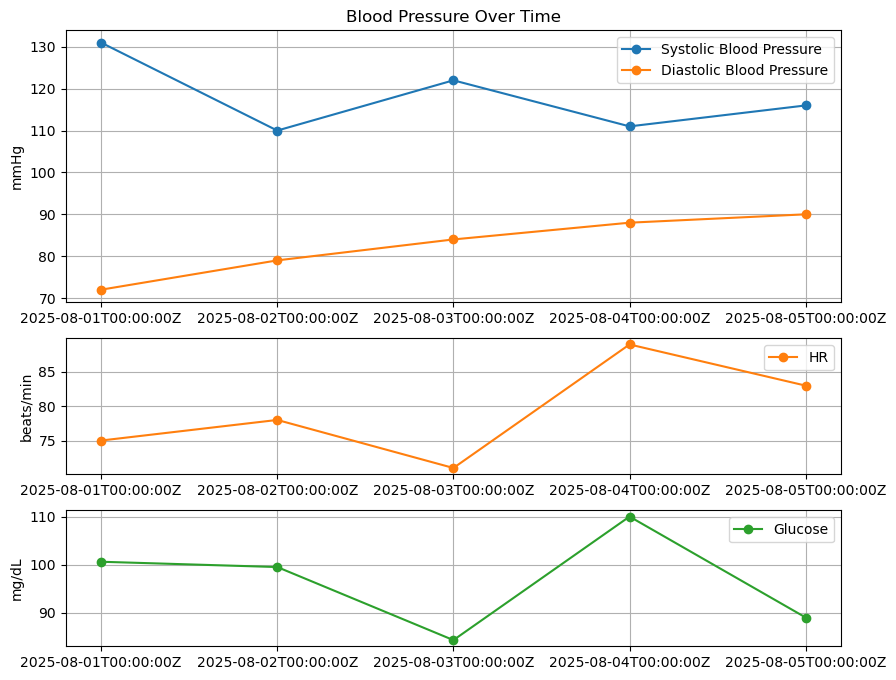

In [15]:
# ok now let's plot!

fig, axes = plt.subplots(3, 1, figsize=(10, 8), gridspec_kw={"height_ratios": [2, 1, 1]})

# show bp on one plot
bp = df[df["code"].str.contains("Blood Pressure")]
for code in ["Systolic Blood Pressure", "Diastolic Blood Pressure"]:
    subset = bp[bp["code"] == code]
    axes[0].plot(subset["time"], subset["value"], marker="o", label=code)
axes[0].set_ylabel("mmHg")
axes[0].set_title("Blood Pressure Over Time")
axes[0].legend()
axes[0].grid(True)

hr = df[df["code"] == "Heart rate"]
axes[1].plot(hr["time"], hr["value"], marker="o", color="tab:orange",label="HR")
axes[1].set_ylabel("beats/min")
axes[1].legend()
axes[1].grid(True)

glucose = df[df["code"] == "Glucose"]
axes[2].plot(glucose["time"], glucose["value"], marker="o", color="tab:green",label="Glucose")
axes[2].set_ylabel("mg/dL")
axes[2].legend()
axes[2].grid(True)


plt.show()

In [ ]:
# if you made it this far congratulations! To extend your knowledge, please
# find a new resource type on the FHIR specification, make some synthetic data
# and retrieve it, showing the data however you like.

# you can browse resources here: https://build.fhir.org/resourcelist.html

Make synthetic data with immunization

In [16]:
{
  "coding": [
    {
      "system": "http://hl7.org/fhir/sid/cvx",
      "code": "102",
      "display": "MMR"
    }
  ]
}

{'coding': [{'system': 'http://hl7.org/fhir/sid/cvx',
   'code': '102',
   'display': 'MMR'}]}

In [17]:
{
  "reference": "Patient/49233412"
}

{'reference': 'Patient/49233412'}

In [18]:
{
  "resourceType": "Immunization",
  "status": "completed",
  "vaccineCode": {
    "coding": [
      {
        "system": "http://hl7.org/fhir/sid/cvx",
        "code": "102",
        "display": "MMR"
      }
    ]
  },
  "patient": {
    "reference": "Patient/49233412"
  },
  "occurrenceDateTime": "2025-08-15T10:00:00Z",
  "performer": [
    {
      "function": {
        "coding": [
          {
            "system": "http://terminology.hl7.org/CodeSystem/v2-0443",
            "code": "AP",
            "display": "Administering Provider"
          }
        ]
      },
      "actor": {
        "reference": "Practitioner/example-practitioner-id"
      }
    }
  ],
  "lotNumber": "ABC12345",
  "expirationDate": "2026-08-15"
}

{'resourceType': 'Immunization',
 'status': 'completed',
 'vaccineCode': {'coding': [{'system': 'http://hl7.org/fhir/sid/cvx',
    'code': '102',
    'display': 'MMR'}]},
 'patient': {'reference': 'Patient/49233412'},
 'occurrenceDateTime': '2025-08-15T10:00:00Z',
 'performer': [{'function': {'coding': [{'system': 'http://terminology.hl7.org/CodeSystem/v2-0443',
      'code': 'AP',
      'display': 'Administering Provider'}]},
   'actor': {'reference': 'Practitioner/example-practitioner-id'}}],
 'lotNumber': 'ABC12345',
 'expirationDate': '2026-08-15'}

In [19]:
import requests
import json

FHIR_BASE = "http://hapi.fhir.org/baseR4"
patient_id = "49233412"

immunization_data = {
  "resourceType": "Immunization",
  "status": "completed",
  "vaccineCode": {
    "coding": [
      {
        "system": "http://hl7.org/fhir/sid/cvx",
        "code": "102",
        "display": "MMR"
      }
    ],
    "text": "MMR"
  },
  "patient": {
    "reference": f"Patient/{patient_id}"
  },
  "occurrenceDateTime": "2025-08-15T10:00:00Z",
  "lotNumber": "ABC12345"
}

response = requests.post(f"{FHIR_BASE}/Immunization", json=immunization_data)
print(f"Status Code: {response.status_code}")
print(response.json())

Status Code: 201
{'resourceType': 'Immunization', 'id': '50166507', 'meta': {'versionId': '1', 'lastUpdated': '2025-10-14T19:33:59.477+00:00', 'source': '#ipCD4S7Yi0VF7q0j'}, 'status': 'completed', 'vaccineCode': {'coding': [{'system': 'http://hl7.org/fhir/sid/cvx', 'code': '102', 'display': 'MMR'}], 'text': 'MMR'}, 'patient': {'reference': 'Patient/49233412'}, 'occurrenceDateTime': '2025-08-15T10:00:00Z', 'lotNumber': 'ABC12345'}


In [20]:
FHIR_BASE = "http://hapi.fhir.org/baseR4"
immunization_id = "50166507"

response = requests.get(f"{FHIR_BASE}/Immunization/{immunization_id}")
print(response.json())

{'resourceType': 'Immunization', 'id': '50166507', 'meta': {'versionId': '1', 'lastUpdated': '2025-10-14T19:33:59.477+00:00', 'source': '#ipCD4S7Yi0VF7q0j'}, 'status': 'completed', 'vaccineCode': {'coding': [{'system': 'http://hl7.org/fhir/sid/cvx', 'code': '102', 'display': 'MMR'}], 'text': 'MMR'}, 'patient': {'reference': 'Patient/49233412'}, 'occurrenceDateTime': '2025-08-15T10:00:00Z', 'lotNumber': 'ABC12345'}
